In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold
from google.colab import files

from sklearn.feature_selection import mutual_info_classif

In [2]:
files.upload()

{}

In [3]:
os.listdir()

['.config', 'sample_data']

In [4]:
def num_derivative(data, steps, epsilon=1e7):
  #return np.array([(data[point] - data[point + 1]) / 2  for point in zip(data, steps)])
  return np.diff(data, prepend=np.nan) / np.diff(steps, prepend=np.nan)

def test_func1(steps):
  return np.sin(steps)

def test_deriv1(steps):
  return np.cos(steps)

##

def test_func2(steps):
  return np.exp(-3 * steps) - 8 * np.exp(-0.5 * steps)

def test_deriv2(steps):
  return -3 * np.exp(-3 * steps) + 4 * np.exp(-0.5 * steps)

In [5]:
steps = np.linspace(-0.2, 10, 1000).reshape(1, -1)

input_deriv = np.concatenate((test_func2(steps), test_deriv2(steps)), axis=0)
aprox_deriv = num_derivative(input_deriv[0, :], steps)

In [6]:
#np.abs(aprox_deriv - input_deriv[1, :])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<ErrorbarContainer object of 3 artists>

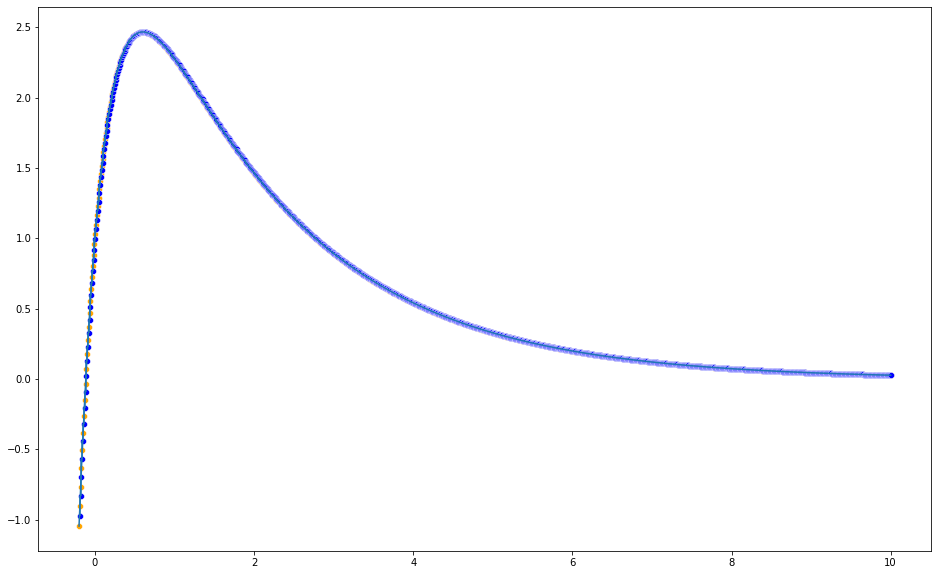

In [7]:
# Exact and approximate solutions
fig, ax = plt.subplots(1,1, figsize=(16, 10))
sns.scatterplot(steps.reshape(-1), 
                test_deriv2(steps).reshape(-1),
                color="orange",
                axes=ax
                )

sns.scatterplot(steps.reshape(-1), 
                aprox_deriv.reshape(-1),
                color="blue",
                axes=ax
                )
ax.errorbar(steps.reshape(-1), test_deriv2(steps).reshape(-1), np.abs(aprox_deriv - input_deriv[1, :]).reshape(-1))
#ax.set_xlim((2, 3))

In [22]:
def load_dataset(dataset_name, skip_age=True):
  data = pd.read_csv(dataset_name)
  full_columns = data.columns
  class2int = {'Positive': 1, 'Negative': 0}
  data.loc[:, 'class'] = data['class'].map(class2int)

  X = data[data.columns[:-1]].values
  y = data['class'].copy()
  if not skip_age:
    return data, X.values, y
  else:
    return data[data.columns[1:]], X[:, 1:], y, dict(zip(y.unique(), ["Pos", "Neg"]))

In [23]:
diabetes, X, y, code2class = load_dataset('diabetes_data_upload.csv')

Number of classes

In [ ]:
diabetes.groupby(['class'], axis=0).size()

class
0    200
1    320
dtype: int64

In [ ]:
# NOTE: filter the ref_dim by ref_class and group by all other variables
def groups_bar_plot(dataframe, ref_dim, ref_class, cols_filter=None, allowInterchange=False):
    # GroupedByDataFrame. Only few unique integers or categorical
    from matplotlib.lines import Line2D

    if not isinstance(cols_filter, type(None)):
      dataframe = dataframe.loc[:, cols_filter]
    dataframe = dataframe.loc[dataframe[ref_dim] == ref_class]
    fig, axes = plt.subplots(dataframe.shape[1] - 1, 1, figsize=(16, 200))
    axes = axes.ravel()
    fig.set_facecolor('silver')
    upper_margin =  50
    yPosition_offset = 0
    bar_height = 0.4
    color_one = 'cyan'
    color_two = 'yellow'
    color_block_greater_prop_1 = "indianred"
    color_block_greater_prop_2 = "maroon"
    color_block_greater_prop_3 = "black"
    bars_positions = np.array([])
    interchange_color = False
    
    main_class = ref_dim # Put in your reference / comparing class

    #axe.tick_params()
    #axe.get_xticklabels()

    for feature, axe in zip(dataframe.columns, axes):
        counts = dataframe.groupby([feature], axis=0).size()
        counts.sort_values(inplace=True)
        total_count = counts.sum()
        equal_prop = 1 / counts.shape[0]
        bar_tick_labels = [feat for feat in counts.index]
            
        if allowInterchange:
            if interchange_color:
                color = color_one
                interchange_color = False
            else:
                color = color_two
                interchange_color = True
        else:
            color = color_one
        if counts.shape[0] != bars_positions.shape[0]:
            #bars_positions = np.arange(0, counts.shape[0] * 2, 2)
            bars_positions = np.arange(0, counts.shape[0])
        #axe.bar(x=bars_positions, height=counts, height=bar_height, color=color)
        axe.barh(y=bars_positions, width=counts, height=bar_height, 
                 color=color, 
                 tick_label=bar_tick_labels)
        
        # Annotation of equal distributed proportion
        axe.annotate("Equal proportion: " + str(100 * np.round(equal_prop, 4)), 
                     xy=(0.7, 0.4), 
                     fontsize=10,
                     weight="bold",
                     xycoords='axes fraction'
                    )
        
        # Axis limits
        axe.set_xlim(0, counts.max() + upper_margin)
        
        # Titles
        axe.set_title("Reference dimension and class: {0} | {1}".format(ref_dim, ref_class))
        
        # Axis labels
        axe.set_xlabel('{0}: [{1}] counts'.format(feature, total_count))
        
        # ticks and tick labels
        axe.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=True) # labels along the bottom edge are off
        #axe.set_yticks(bars_positions)
        #axe.set_xticklabels([code2class[class_] + " | " + feat for class_, feat in counts.index])
        #axe.set_yticklabels(bar_tick_labels)
        #axe.tick_params(rotation=10)
        
        for block in list(axe.containers[0]): 
            # Percentage of total counts
            perc_counts = np.round(100 * block.get_width() / total_count, 2)
            # Annotate the percentage on the edge of the bar
            axe.annotate(str(perc_counts), xy=(block.get_width() + yPosition_offset, 
                                               block.get_y() + bar_height / 2
                                               ),
                         fontsize=10,
                         weight="bold"
                        )
            
            # Equal proportion in the grouping based on number of groups
            block_proportion = block.get_width() / total_count
            
            # If block is greater than the proportion: simply greater or twice greater
            if block_proportion > equal_prop:
                if (block_proportion) > (equal_prop * 2):
                  block.set_facecolor(color_block_greater_prop_2)
            else:
                block.set_facecolor(color_block_greater_prop_1)
        # Customized handles for legend
        custom_lines = [Line2D([0], [0], color=color_one, lw=4), #cmap(.5)
                        Line2D([0], [0], color=color_block_greater_prop_1, lw=4)
                       ]
        # plot legend
        axe.legend(handles=custom_lines,
                   labels=["Less than equal proportion (E.Q.)",
                           "More than one E.Q.",
                          ],
                   loc=4 # 7 - "center right"; 4 - "lower right"
                  )
    plt.tight_layout()

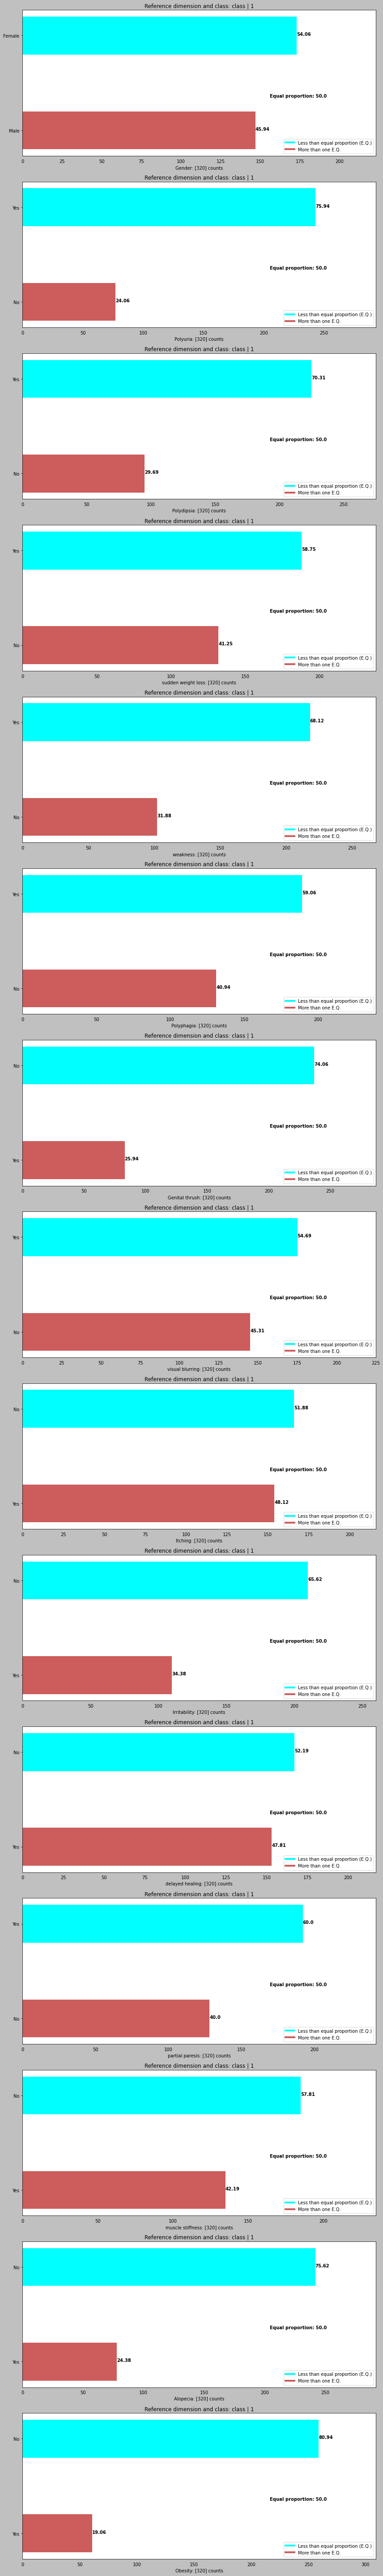

In [ ]:
groups_bar_plot(diabetes, "class", 1)

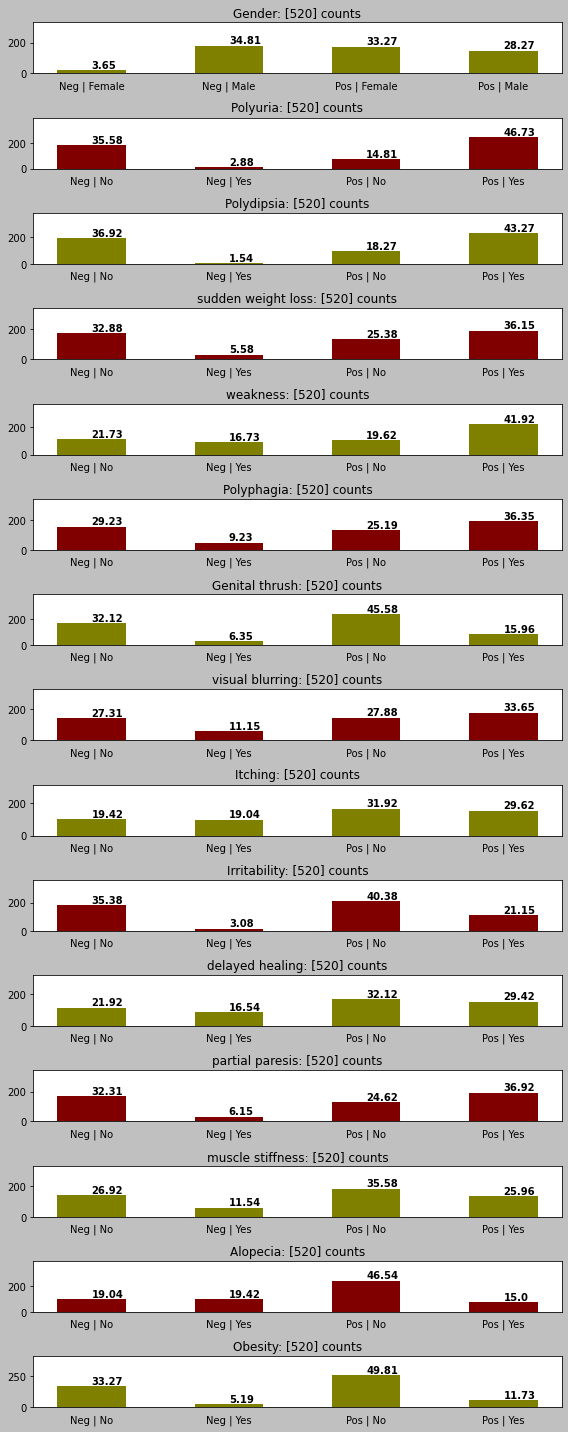

In [ ]:
fig, axes = plt.subplots(diabetes.shape[1] - 1, 1, figsize=(8, 20))
fig.set_facecolor('silver')
upper_margin =  150
yPosition_offset =  15
bar_width = 0.5
color_one = 'maroon'
color_two = 'olive'
bars_positions = np.array([])

interchange_color = False

#axe.tick_params()
#axe.get_xticklabels()

for feature, axe in zip(diabetes.columns[:-1], axes):
  counts = diabetes.groupby(['class', feature], axis=0).size()
  total_count = counts.sum()

  if interchange_color:
    color = color_one
    interchange_color = False
  else:
    color = color_two
    interchange_color = True
  if counts.shape[0] != bars_positions.shape[0]:
    bars_positions = np.arange(counts.shape[0]) + 1
  axe.bar(bars_positions, counts, width=bar_width, color=color)
  axe.set_title('{0}: [{1}] counts'.format(feature, total_count))
  axe.set_ylim(0, counts.max() + upper_margin)
  axe.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=True) # labels along the bottom edge are off
  axe.set_xticks(bars_positions)
  axe.set_xticklabels([code2class[class_]+ " | " + feat for class_, feat in counts.index])

  for block in list(axe.containers[0]):
    # Percentage of total counts
    perc_counts = np.round(100 * block.get_height() / total_count, 2)
    axe.annotate(str(perc_counts), xy=(block.get_x() + bar_width / 2, 
                                       block.get_height() + yPosition_offset), 
                 fontsize=10,
                 weight="bold"
                 )
    
plt.tight_layout()

In [ ]:
diabetes_dummy = pd.get_dummies(diabetes[diabetes.columns[: -1]], 
                                drop_first=True)

interactions_df = pd.DataFrame()
dummy_columns = diabetes_dummy.columns
interaction_columns = list()

columns = diabetes_dummy.columns[:-1]
c = 0

for dummy1 in columns[:-1]:
  c += 1
  for dummy2 in columns[c:]:
    dummy_pair = diabetes_dummy[dummy1].mul(diabetes_dummy[dummy2])
    interaction_columns.append('-'.join([dummy1, dummy2]))
    interactions_df = pd.concat((interactions_df, dummy_pair), axis=1)

print("Number of interactions:", 14 * (14 - 1) / 2)

print("Number of interactions created:",len(interaction_columns))
interactions_df.columns = interaction_columns
diabetes_plus_inter = pd.concat((interactions_df, diabetes), axis=1)

#interactions_df = pd.concat((interactions_df, diabetes['class']), axis=1)

Number of interactions: 91.0
Number of interactions created: 91


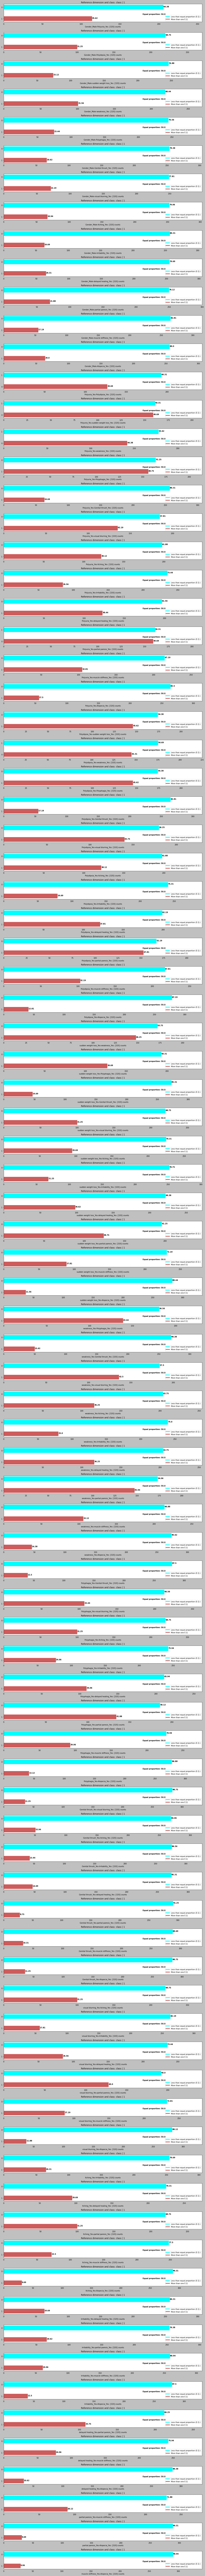

In [ ]:
groups_bar_plot(pd.concat((interactions_df, diabetes["class"]), axis=1), "class", 1)

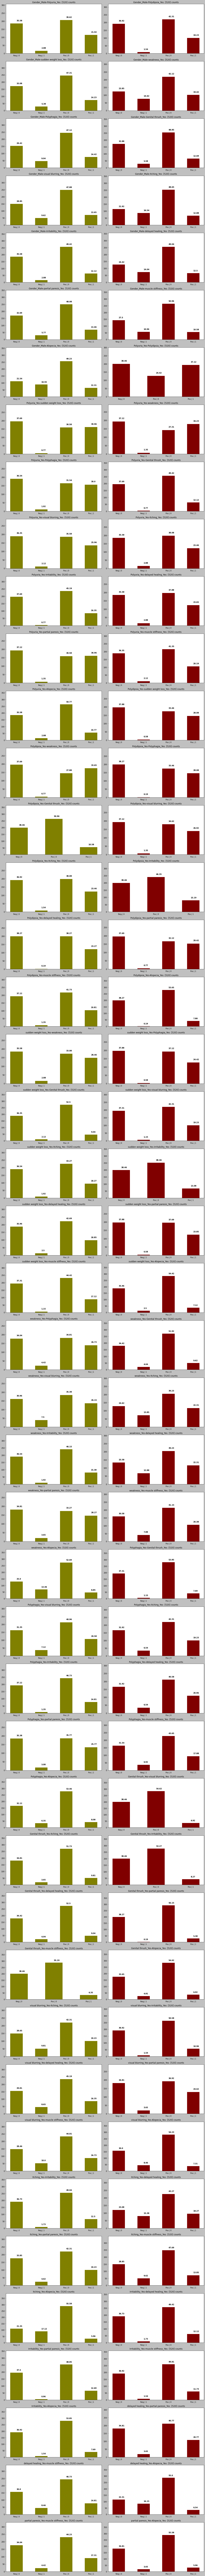

In [ ]:
fig, axes = plt.subplots(len(interaction_columns) // 2, 2, figsize=(16, 200))
fig.set_facecolor('silver')
upper_margin =  100
yPosition_offset =  15
bar_width = 0.5
color_maroon = 'maroon'
color_olive = 'olive'
bars_positions = np.array([])

interchange_color = False

#axe.tick_params()
#axe.get_xticklabels()

for feature, axe in zip(interaction_columns, axes.ravel()):
  counts = pd.concat((interactions_df, diabetes["class"]), axis=1).groupby(['class', feature], axis=0).size()
  total_count = counts.sum()

  if interchange_color:
    color = color_maroon
    interchange_color = False
  else:
    color = color_olive
    interchange_color = True
  if counts.shape[0] != bars_positions.shape[0]:
    bars_positions = np.arange(counts.shape[0]) + 1
  axe.bar(bars_positions, counts, width=bar_width, color=color)
  axe.set_title('{0}: [{1}] counts'.format(feature, total_count))
  axe.set_ylim(0, counts.max() + upper_margin)
  axe.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=True) # labels along the bottom edge are off
  axe.set_xticks(bars_positions)
  axe.set_xticklabels([code2class[class_]+ " | " + str(state) for class_, state in counts.index])

  for block in list(axe.containers[0]):
    # Percentage of total counts
    perc_counts = np.round(100 * block.get_height() / total_count, 2)
    axe.annotate(str(perc_counts), xy=(block.get_x() + bar_width / 2, 
                                       block.get_height() + yPosition_offset), 
                 fontsize=10,
                 weight="bold"
                 )
    
plt.tight_layout()

### Study of MI

In [ ]:
aux_df = diabetes_plus_inter[diabetes_plus_inter.columns[:-1]]
aux_dimensions = aux_df.columns
dim_number = len(aux_dimensions)

mutual_info_df = pd.DataFrame(np.zeros((dim_number, dim_number)), columns=aux_dimensions, index=aux_dimensions)

for column_1 in aux_dimensions:
  for column_2 in aux_dimensions:
    if column_1 != column_2:
      cell_mutual_info = mutual_info_classif(aux_df[column_1].values.reshape(-1, 1), aux_df[column_2].values,
                                            discrete_features=True,
                                            random_state=117)
      #cell_mutual_info = entropy(aux_df[column_1].values, aux_df[column_2].values, 
      #                           base=2)
      mutual_info_df.loc[column_1, column_2] = cell_mutual_info

print("Number of 'MI scores': ", dim_number * dim_number - dim_number)

In [ ]:
signficant_MI = (mutual_info_df >= 0.2)

print("How many dimensions don't share significant MI with other dimensions?")
print(106 - signficant_MI.any(axis=1).sum())

In [ ]:
# Number of high MI by row
number_significance_per_dim = signficant_MI.values.sum(axis=1)
number_significance_per_dim

In [ ]:
mask_selected_dimensions = number_significance_per_dim < 5
mask_selected_dimensions.sum()

77

In [ ]:
selected_dimensions = diabetes_plus_inter.columns[:-1][mask_selected_dimensions]
selected_dimensions.shape

In [ ]:
selected_dimensions

Index(['Gender_Male-Polyuria_Yes', 'Gender_Male-Polydipsia_Yes',
       'Gender_Male-sudden weight loss_Yes', 'Gender_Male-weakness_Yes',
       'Gender_Male-Polyphagia_Yes', 'Gender_Male-Genital thrush_Yes',
       'Gender_Male-visual blurring_Yes', 'Gender_Male-Itching_Yes',
       'Gender_Male-Irritability_Yes', 'Gender_Male-delayed healing_Yes',
       'Gender_Male-partial paresis_Yes', 'Gender_Male-muscle stiffness_Yes',
       'Gender_Male-Alopecia_Yes', 'Polyuria_Yes-weakness_Yes',
       'Polyuria_Yes-Genital thrush_Yes', 'Polyuria_Yes-visual blurring_Yes',
       'Polyuria_Yes-Itching_Yes', 'Polyuria_Yes-Irritability_Yes',
       'Polyuria_Yes-muscle stiffness_Yes', 'Polyuria_Yes-Alopecia_Yes',
       'Polydipsia_Yes-Genital thrush_Yes', 'Polydipsia_Yes-Itching_Yes',
       'Polydipsia_Yes-Irritability_Yes', 'Polydipsia_Yes-delayed healing_Yes',
       'Polydipsia_Yes-muscle stiffness_Yes', 'Polydipsia_Yes-Alopecia_Yes',
       'sudden weight loss_Yes-Genital thrush_Yes',
    

Let's say we want no more than 4 variables that share significant MI with other dimensions

In [ ]:
"""age_ranges = {"16-25": (16, 25), "26-35": (26, 35), "36-45": (36, 45), "46-55": (46, 55), "56-65": (56, 65), ">65": (66, 100)}
pd.IntervalIndex.from_tuples(age_ranges.values())

X.Age = pd.cut(X.Age, bins=pd.IntervalIndex.from_tuples(age_ranges.values()))
X.Age.cat.rename_categories(np.arange(len(X.Age.cat.categories)), inplace=True)"""

'age_ranges = {"16-25": (16, 25), "26-35": (26, 35), "36-45": (36, 45), "46-55": (46, 55), "56-65": (56, 65), ">65": (66, 100)}\npd.IntervalIndex.from_tuples(age_ranges.values())\n\nX.Age = pd.cut(X.Age, bins=pd.IntervalIndex.from_tuples(age_ranges.values()))\nX.Age.cat.rename_categories(np.arange(len(X.Age.cat.categories)), inplace=True)'

In [ ]:
# Reformat strings to integers
diabetes_plus_inter.loc[:, diabetes.columns[:-1]] = diabetes_plus_inter.loc[:, diabetes.columns[:-1]].applymap(lambda element: 1 if element in ["Male", "Yes"] else 0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import learning_curve

In [ ]:
def split_fit(X, y, model, train_size=0.75, random_state=117, return_model=True):
  X_train, X_test, y_train, y_test = train_test_split(X, 
                                                      y, 
                                                      train_size=train_size, 
                                                      random_state=random_state)
  if return_model:
    return X_train, X_test, y_train, y_test, model.fit(X_train, y_train)
  return X_train, X_test, y_train, y_test

def report_model_regular_split(X, y, model_base, return_model=False):
  _, X_test, _, y_test, classifier = split_fit(X, y, model_base)
  
  print(print(classification_report(classifier.predict(X_test), y_test)))

  return classifier if return_model else None

## Machine Learning Model: Marginal features + Logistic Regression

## Machine Learning Model: Marginal features + Gradient boosting

We will use this model to get insights about the importante of the features. Hence, we will be able to pin-point crucial features and eventually reduce the size of the model, in terms of weights, to get a even a simpler model.

In [ ]:
X_marginal = diabetes_plus_inter.iloc[:, :15].values

In [ ]:
X_train_mar, X_test_mar, y_train_mar, y_test_mar = train_test_split(X_marginal,
                                                                    y,
                                                                    train_size=0.90,
                                                                    random_state=117)

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_mar,
                                                  y_train_mar,
                                                  train_size=0.75,
                                                  random_state=117)

In [ ]:
classifier_simple = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100).fit(X_train, y_train)

In [ ]:
report_GBC = classification_report(classifier_simple.predict(X_dev), y_dev)
print(report_GBC)

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        47
           1       0.88      1.00      0.93        70

    accuracy                           0.91       117
   macro avg       0.94      0.89      0.91       117
weighted avg       0.93      0.91      0.91       117



In [ ]:
feature2importance = dict(zip(diabetes.columns[:-1], classifier_simple.feature_importances_))
feature2importance.keys()

dict_keys(['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity'])

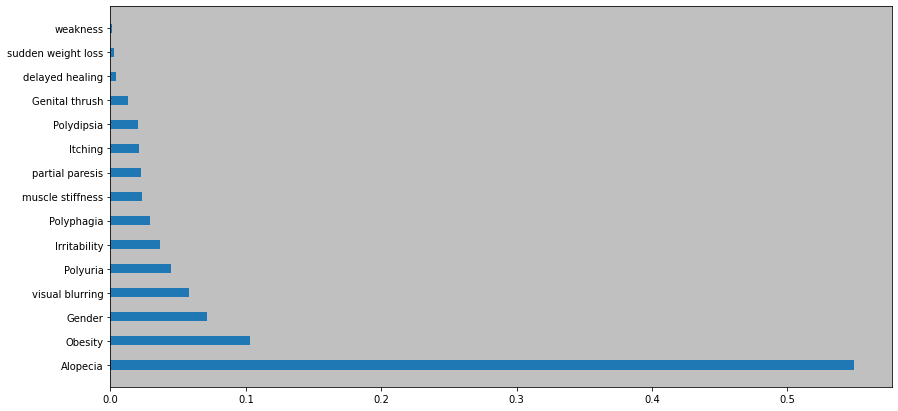

In [ ]:
def show_imporances(classifier, features):
  from collections import OrderedDict

  bar_positions = range(0, classifier.feature_importances_.shape[0]*2, 2)
  importances = classifier.feature_importances_
  feature2importante = OrderedDict(sorted([(feature, importance) for feature, importance in zip(features, importances)], key=lambda x: x[1], reverse=True))

  fig, axes = plt.subplots(1, figsize=(14,7))
  fig.set_facecolor('white')
  axes.set_facecolor('silver')
  
  axes.barh(bar_positions, feature2importante.values())
  axes.set_yticks(bar_positions)
  axes.set_yticklabels(feature2importante.keys(), fontdict={'fontsize':10}, minor=False, rotation='horizontal')

  return axes

show_imporances(classifier_simple, diabetes.columns[:-1])

In [ ]:
classifier_simple = LogisticRegression().fit(X_train_mar, y_train_mar)

In [ ]:
report_simple = classification_report(classifier_simple.predict(X_dev), y_dev)
print(report_simple)

              precision    recall  f1-score   support

           0       0.95      0.73      0.82        48
           1       0.84      0.97      0.90        69

    accuracy                           0.87       117
   macro avg       0.89      0.85      0.86       117
weighted avg       0.88      0.87      0.87       117



## Machine Learning Model: Interactions + Logistic Regression

In [ ]:
X_full = diabetes_plus_inter.loc[:, selected_dimensions ].values # diabetes_plus_inter.columns != "class"

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full,
                                                                        y, 
                                                                        train_size=0.90,
                                                                        random_state=117)

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, 
                                                  y_train_full, 
                                                  train_size=0.75, 
                                                  random_state=117)

In [ ]:
classifier_inter = LogisticRegression().fit(X_train, y_train)

In [ ]:
#precision_recall_fscore_support(classifier.predict(X_test), y_test)
report_inter = classification_report(classifier_inter.predict(X_dev), y_dev)
print(report_inter)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93        38
           1       0.96      0.97      0.97        79

    accuracy                           0.96       117
   macro avg       0.95      0.95      0.95       117
weighted avg       0.96      0.96      0.96       117



In [ ]:
cross_var_scores = cross_validate(LogisticRegression(max_iter=200), X_train, y_train, scoring=['precision', 'recall'], cv=6)
pd.DataFrame(cross_var_scores)

,fit_time,score_time,test_precision,test_recall
0,0.016462,0.003064,0.944444,0.971429
1,0.012347,0.002748,0.941176,0.914286
2,0.011562,0.002685,0.970588,0.942857
3,0.012167,0.002713,0.945946,1.000000
4,0.012454,0.002692,0.968750,0.885714
5,0.010425,0.002644,1.000000,0.857143


## Machine Learning Model: Interactions (selected by feature selection) + Logistic Regression

Feature selection

In [ ]:
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest, SelectFpr, SelectFdr, SelectPercentile

### Chi-square test

Apply the model on X reduced by Chi2

In [ ]:
X_train_full_chi, X_test_full_chi, y_train_full_chi, y_test_full_chi = train_test_split(X_full,
                                                                                        y, 
                                                                                        train_size=0.90,
                                                                                        random_state=117)

In [ ]:
X_chi = SelectKBest(chi2, 75).fit_transform(X_train_full_chi, y_train_full_chi)

In [ ]:
chi_scores = chi2(X_train_full_chi, y_train_full_chi)
chi_scores = [score for score in chi_scores[1]]

<BarContainer object of 77 artists>

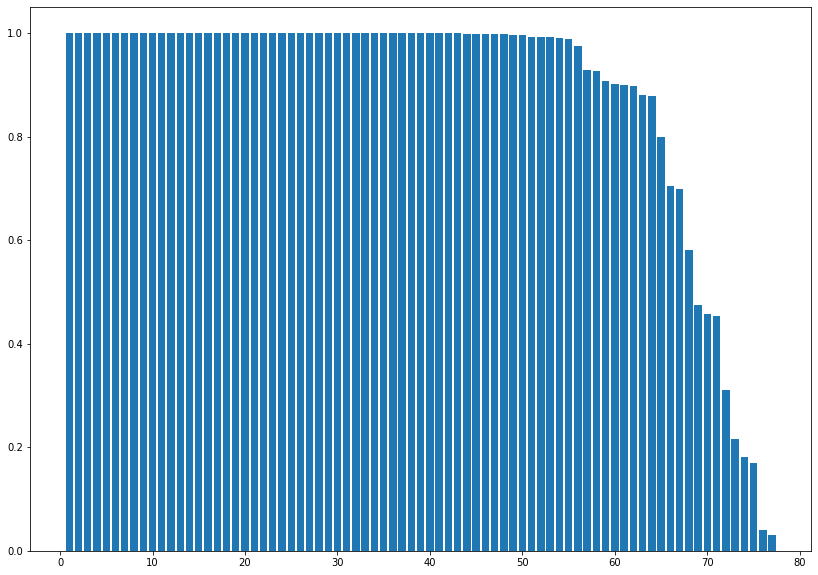

In [ ]:
fig, axes5 = plt.subplots(1, 1, figsize=(14, 10)) # , figsize=(20, 14)
# We plot the complement of p-values, that is to say, 1-p-values (the probability of not getting an extreme
# result under the truth of H0).
axes5.bar(range(1, len(chi_scores) + 1), 1 - np.array(sorted(chi_scores, reverse=False)))

In [ ]:
chi_scores = [(score, position) for position, score in enumerate(chi_scores)]
chi_scores = sorted(chi_scores, key=lambda pair: pair[0], reverse=False)

index = [index[1] for index in chi_scores]

diabetes_plus_inter.columns[index[:10]]

Index(['Gender_Male-Polyuria_Yes', 'Gender_Male-Polydipsia_Yes',
       'Gender_Male-sudden weight loss_Yes', 'Gender_Male-weakness_Yes',
       'Gender_Male-Polyphagia_Yes', 'Gender_Male-Genital thrush_Yes',
       'Gender_Male-visual blurring_Yes', 'Gender_Male-Itching_Yes',
       'Gender_Male-Irritability_Yes', 'Gender_Male-delayed healing_Yes'],
      dtype='object')

In [ ]:
X_train_chi2, X_dev_chi2, y_train_chi2, y_dev_chi2 = train_test_split(X_train_full_chi, 
                                                                      y_train_full_chi, 
                                                                      train_size=0.75, 
                                                                      random_state=117)

classifier_chi = LogisticRegression(max_iter=200, random_state=117)

cross_var_scores = cross_validate(classifier_chi, X_train_chi2, y_train_chi2, scoring=['precision', 'recall'], cv=6)
pd.DataFrame(cross_var_scores)

,fit_time,score_time,test_precision,test_recall
0,0.010895,0.002684,0.944444,0.971429
1,0.012608,0.002762,0.941176,0.914286
2,0.012096,0.002745,0.970588,0.942857
3,0.012478,0.002981,0.945946,1.000000
4,0.018726,0.002773,0.968750,0.885714
5,0.010902,0.002691,1.000000,0.857143


In [ ]:
classifier_chi.fit(X_train_chi2, y_train_chi2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=117, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
confusion_matrix(classifier_chi.predict(X_dev_chi2), y_dev_chi2)

array([[35,  3],
       [ 2, 77]])

In [ ]:
report_full_chi = classification_report(classifier_chi.predict(X_dev_chi2), y_dev_chi2, digits=4)
print(report_full_chi)

              precision    recall  f1-score   support

           0     0.9459    0.9211    0.9333        38
           1     0.9625    0.9747    0.9686        79

    accuracy                         0.9573       117
   macro avg     0.9542    0.9479    0.9509       117
weighted avg     0.9571    0.9573    0.9571       117



### Mutual information

Apply the model on X reduced by Mutual information

In [ ]:
X_mi = SelectKBest(mutual_info_classif, 50).fit_transform(X_full, y)

In [ ]:
X_train_full_mi, X_test_full_mi, y_train_full_mi, y_test_full_mi = train_test_split(X_mi,
                                                                                    y, 
                                                                                    train_size=0.90,
                                                                                    random_state=117)

SyntaxError: ignored

<BarContainer object of 50 artists>

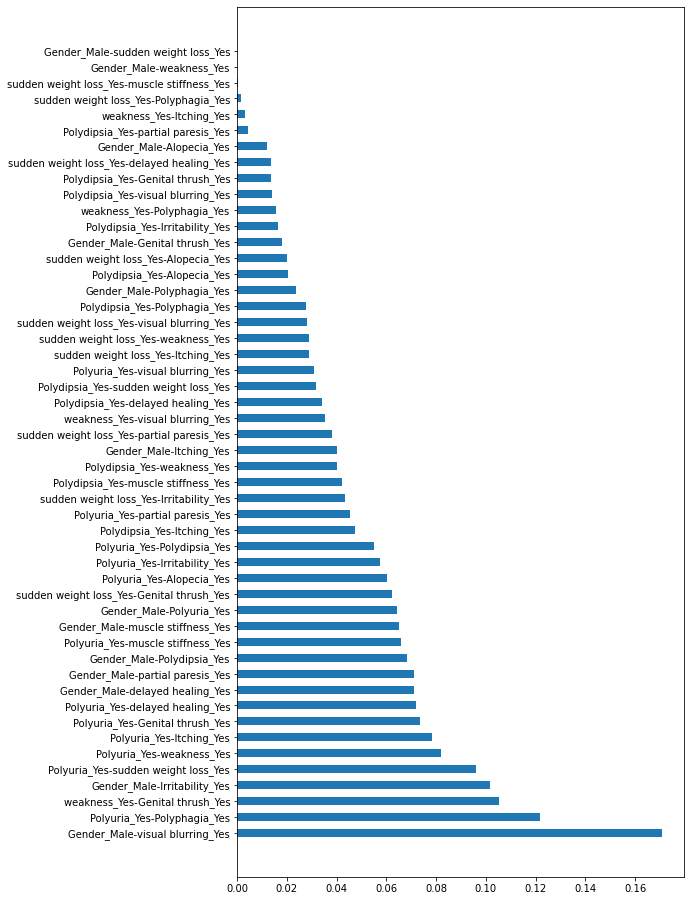

In [ ]:
MI_scores = mutual_info_classif(X_train_full_mi, y_train_full_mi, discrete_features=True, random_state=117)

#fig, axes4 = plt.subplots(1, 1, figsize=(16, 8)) # , figsize=(20, 14)
#axes4.bar(range(1, len(MI_scores) + 1), sorted(MI_scores, reverse=True))

MI_scores_pos = [(score, position) for position, score in enumerate(MI_scores)]
MI_scores_pos = sorted(MI_scores_pos, key=lambda pair: pair[0], reverse=True)

col_indices = [col_score[1] for col_score in MI_scores_pos]


fig, axes4 = plt.subplots(1, 1, figsize=(8, 16)) # , figsize=(20, 14)
axes4.barh(height=0.5, y=range(1, len(MI_scores) + 1), width=sorted(MI_scores, reverse=True), 
          tick_label=diabetes_plus_inter.columns[index])

In [ ]:
col_indices = [col_score[1] for col_score in MI_scores]
diabetes_plus_inter.columns[index[:10]]

Index(['Gender_Male-visual blurring_Yes', 'Polyuria_Yes-Polyphagia_Yes',
       'weakness_Yes-Genital thrush_Yes', 'Gender_Male-Irritability_Yes',
       'Polyuria_Yes-sudden weight loss_Yes', 'Polyuria_Yes-weakness_Yes',
       'Polyuria_Yes-Itching_Yes', 'Polyuria_Yes-Genital thrush_Yes',
       'Polyuria_Yes-delayed healing_Yes', 'Gender_Male-delayed healing_Yes'],
      dtype='object')

In [ ]:
X_train_mi, X_dev_mi, y_train_mi, y_dev_mi = train_test_split(X_mi, 
                                                              y, 
                                                              train_size=0.85, 
                                                              random_state=117)

classifier_mi = LogisticRegression(max_iter=200, 
                                   random_state=117, 
                                   class_weight="balanced"
                                   )

cross_var_scores = cross_validate(classifier_mi, X_train_mi, y_train_mi, scoring=['precision', 'recall'], cv=6)
pd.DataFrame(cross_var_scores)

,fit_time,score_time,test_precision,test_recall
0,0.018422,0.002794,0.977273,0.955556
1,0.011778,0.002686,0.976744,0.933333
2,0.012568,0.002749,0.976190,0.911111
3,0.012183,0.002744,0.954545,0.913043
4,0.010497,0.002810,1.000000,0.888889
5,0.011113,0.002727,0.952381,0.888889


In [ ]:
classifier_mi.fit(X_train_mi, y_train_mi)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=117, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
confusion_matrix(classifier_mi.predict(X_dev_mi), y_dev_mi)

array([[28,  5],
       [ 1, 44]])

In [ ]:
report_full_mi = classification_report(classifier_mi.predict(X_dev_mi), y_dev_mi, digits=4)
print(report_full_mi)

              precision    recall  f1-score   support

           0     0.9655    0.8485    0.9032        33
           1     0.8980    0.9778    0.9362        45

    accuracy                         0.9231        78
   macro avg     0.9317    0.9131    0.9197        78
weighted avg     0.9265    0.9231    0.9222        78



## Compare classification report of four classifiers

In [ ]:
print(report_simple)

              precision    recall  f1-score   support

           0       0.95      0.73      0.82        48
           1       0.84      0.97      0.90        69

    accuracy                           0.87       117
   macro avg       0.89      0.85      0.86       117
weighted avg       0.88      0.87      0.87       117



In [ ]:
print(report_inter)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93        38
           1       0.96      0.97      0.97        79

    accuracy                           0.96       117
   macro avg       0.95      0.95      0.95       117
weighted avg       0.96      0.96      0.96       117



In [ ]:
print(report_full_chi)

              precision    recall  f1-score   support

           0     0.9459    0.9211    0.9333        38
           1     0.9625    0.9747    0.9686        79

    accuracy                         0.9573       117
   macro avg     0.9542    0.9479    0.9509       117
weighted avg     0.9571    0.9573    0.9571       117



In [ ]:
print(report_full_mi)

              precision    recall  f1-score   support

           0     0.9655    0.8485    0.9032        33
           1     0.8980    0.9778    0.9362        45

    accuracy                         0.9231        78
   macro avg     0.9317    0.9131    0.9197        78
weighted avg     0.9265    0.9231    0.9222        78



We can conclude that the feature selection through chi square brings/gives better results as we can appreciate from the classification report.

Even though the model which takes 107 features gives a slightly better model, in terms of metric scores, we will prefer the model obtained by calculating chi2 over the former, because it takes, less features.

Let's work out the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) curve:

In [ ]:
# Full model
roc_auc_score(classifier_inter.predict(X_dev), y_dev)

0.9478680879413723

In [ ]:
# Partial model - MI
roc_auc_score(classifier_mi.predict(X_dev_mi), y_dev_mi)

0.9131313131313132

In [ ]:
# Partial model - Chi2
roc_auc_score(classifier_chi.predict(X_dev_chi2), y_dev_chi2)

0.9478680879413723

In [ ]:
decision_score = classifier_chi.decision_function(X_dev_chi2)
fpr, tpr, threshold = roc_curve(y_dev_chi2, decision_score)

In [ ]:
#auc(fpr, tpr)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


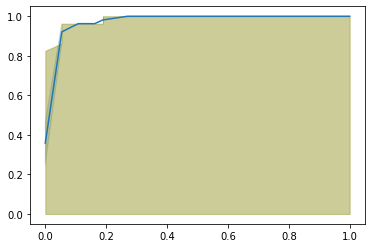

In [ ]:
sns.lineplot(fpr, tpr)
plt.fill_between(fpr, tpr, np.repeat(tpr.min(), fpr.shape[0]), 
                 alpha=0.4, color="olive")